# Documentation

Tuto classif avec camembert : https://xiaoouwang.medium.com/classification-de-commentaires-avec-camembert-sans-prise-de-t%C3%AAte-les-fondamentaux-dbf8070f679b  
Tuto fine-tuning avec sentence-bert : https://h4c5.hashnode.dev/finetuner-un-modele-camembert-pour-lembedding-de-phrases  
Tuto fine-tuning Camembert pour NER : https://www.quantmetry.com/blog/fine-tune-modele-bert-tache-ner/  
Article expliquant les Transformers : https://www.hugomichel.io/post/transformer/  
Huggingface Camembert : https://huggingface.co/docs/transformers/model_doc/camembert#transformers.CamembertModel  
Article sur la fonction de coût pour classification multi-label : https://medium.com/@kitkat73275/multi-label-classification-8d8ae55e8373  
Implémentation de la fonction de coût dans un modèle DL : https://machinelearningmastery.com/multi-label-classification-with-deep-learning/  

In [31]:
!pip install transformers
!pip install sentencepiece
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.0 MB/s eta 0:00:00


# Imports

In [2]:
# Misc
import os
import s3fs

# pre-trained Model
from transformers import CamembertTokenizer, CamembertForSequenceClassification

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, accuracy_score
import matplotlib.pyplot as plt

# Pytorch
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [3]:
os.environ["AWS_S3_ENDPOINT"]
S3_ENDPOINT_URL  = 'https://'+os.environ['AWS_S3_ENDPOINT']
fs = s3fs.S3FileSystem(client_kwargs = {'endpoint_url' : S3_ENDPOINT_URL})
fs.ls('')

['nsimonovici-ensae']

In [4]:
BUCKET = "nsimonovici-ensae"
DIR_KEY_S3 = "PROJET/data/"
FILE_KEY_S3 = 'project-1-at-2024-12-27-15-41-3fe0002a_prepared.csv'
s3_path = f"s3a://{BUCKET}/{DIR_KEY_S3}{FILE_KEY_S3}"
s3_path

's3a://nsimonovici-ensae/PROJET/data/project-1-at-2024-12-27-15-41-3fe0002a_prepared.csv'

In [5]:
with fs.open(s3_path, mode = 'r') as file_in : 
    data_raw = pd.read_csv(file_in, sep=";")

print(f"{data_raw.shape[0]} Lignes et {data_raw.shape[1]} Colonnes")
data_raw.head()

1263 Lignes et 10 Colonnes


,inner_id,topic,topic_idx,data.text,data.name,file_upload,id,data.url,data.username,data.date
0,1,"[""social""]",[11],Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,1,https://bsky.app/profile/fabiennekeller.bsky.s...,ensembleue.bsky.social,2024-11-25 19:25:10.459000
1,2,"[""social""]",[11],La violence à l’égard des femmes reste une urg...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,2,https://bsky.app/profile/mariepierrev.bsky.soc...,ensembleue.bsky.social,2024-11-25 19:24:48.661000
2,3,"[""international"",""économie""]","[8,3]","« Notre position sur le Mercosur, depuis 2019,...",L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,3,https://bsky.app/profile/ensembleue.bsky.socia...,ensembleue.bsky.social,2024-11-25 13:42:39.117000
3,4,"[""international"",""économie"",""social""]","[8,3,11]",Nouvelle session plénière à Strasbourg ! À l’o...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,4,https://bsky.app/profile/ensembleue.bsky.socia...,ensembleue.bsky.social,2024-11-25 12:59:05.431000
4,5,"[""international"",""immigration""]","[8,7]",Désaveu cinglant pour Meloni qui se résout à r...,L’Europe Ensemble,1de050d6-bluesky-comptes-politiques-2_.csv,5,https://bsky.app/profile/fabiennekeller.bsky.s...,ensembleue.bsky.social,2024-11-25 12:50:04.455000


# CamemBert

In [7]:
# # tokenizer = AutoTokenizer.from_pretrained("almanach/camembert-base")
# model = CamembertModel.from_pretrained("almanach/camembert-base")

In [ ]:
# model.state_dict().keys() # Affiche les poids

In [ ]:
# for module in model.modules(): # Affiche les 'modules' dont les couches
#     print(module)

## Entraînement ou non des couches cachées
Les couches sont toutes trainable de base.  
On veut les rendre non-trainable pour le fine-tuning avec un petit jeu de données  
Voir cet article qui discute du sujet : https://discuss.huggingface.co/t/the-point-of-using-pretrained-model-if-i-dont-freeze-layers/40675

In [8]:
# for param in model.parameters():
#     param.requires_grad = False

In [9]:
# print(f"num params:", model.num_parameters())
# print(f"num trainable params:", model.num_parameters(only_trainable=True))

## Fonction de coût :  
What you want is multi-label classification, so you will use Binary Cross-Entropy Loss or Sigmoid Cross-Entropy loss. It is a Sigmoid activation plus a Cross-Entropy loss. Unlike Softmax loss it is independent for each vector component (class), meaning that the loss computed for every CNN output vector component is not affected by other component values. That’s why it is used for multi-label classification, where the insight of an element belonging to a certain class should not influence the decision for another class.

## Altération du model : couches de fine-tuning

In [10]:
# def get_finetuning_model(n_outputs):
# 	model = Sequential()
# 	model.out = Linear(n_outputs, activation='sigmoid')
# 	model.compile(loss='binary_crossentropy', optimizer='adam')
# 	return model

In [67]:
# model.fineTuning = get_finetuning_model(16)

# Fine-Tuning

## Chargement du modèle et du tokenizer

In [6]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=16, problem_type="multi_label_classification")

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))

num params: 110634256
num trainable params: 110634256


Utilisation des "named_modules" pour identifier le classifieur à la tête du réseau

In [9]:
for mod_name, mod in model.named_modules():
    if len(mod_name) > 0:
        if not mod_name.startswith('classifier'):
            print(f"Setting module ***{mod_name}*** non-trainable")
            for param in mod.parameters():
                param.requires_grad = False
        else:
            print(f"Letting module ***{mod_name}*** trainable")

Setting module ***roberta*** non-trainable
Setting module ***roberta.embeddings*** non-trainable
Setting module ***roberta.embeddings.word_embeddings*** non-trainable
Setting module ***roberta.embeddings.position_embeddings*** non-trainable
Setting module ***roberta.embeddings.token_type_embeddings*** non-trainable
Setting module ***roberta.embeddings.LayerNorm*** non-trainable
Setting module ***roberta.embeddings.dropout*** non-trainable
Setting module ***roberta.encoder*** non-trainable
Setting module ***roberta.encoder.layer*** non-trainable
Setting module ***roberta.encoder.layer.0*** non-trainable
Setting module ***roberta.encoder.layer.0.attention*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.query*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.key*** non-trainable
Setting module ***roberta.encoder.layer.0.attention.self.value*** non-trainable
Setting m

In [14]:
print(f"num params:", model.num_parameters())
print(f"num trainable params:", model.num_parameters(only_trainable=True))

num params: 110634256
num trainable params: 602896


In [33]:
for module in model.modules(): # Affiche les 'modules' dont les couches
    print(module)

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

In [16]:
# help(module)

In [10]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias

## Préparation des données
- Assurez-vous que vos données sont sous forme de texte et de labels multi-labels (par exemple, une liste de listes de labels).
- Tokenisez les textes et convertissez les labels en tenseurs PyTorch.

In [11]:
texts = data_raw['data.text'].tolist()
print(len(texts))
texts[0]

1263


'Stop #ViolenceAgainstWomen!\n\n#OrangeTheWorld \n\n📍 Parlement européen, Strasbourg 🧡'

In [12]:
labels_arr = np.zeros((len(texts), 16))
labels_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(1263, 16))

In [13]:
labels_raw = data_raw['topic_idx'].tolist()
labels_ints = []
for labs in labels_raw:
    labels_ints.append([int(value) for value in labs.replace('[', '').replace(']', '').split(',')])
labels_ints[:5]

[[11], [11], [8, 3], [8, 3, 11], [8, 7]]

In [14]:
for i in range(labels_arr.shape[0]):
    labs = labels_ints[i]
    for value in labs:
        labels_arr[i, value] = 1
labels_arr        

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(1263, 16))

In [15]:
labels_list = labels_arr.tolist()
labels_list[:5]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0]]

### Split train/test/val

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(texts, labels_list, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

print(f"Taille jeu d'entraînement = {len(X_train)}")
print(f"Taille jeu de validation = {len(X_val)}")
print(f"Taille jeu de test = {len(X_test)}")

Taille jeu d'entraînement = 909
Taille jeu de validation = 101
Taille jeu de test = 253


In [17]:
inputs_train = tokenizer(X_train, padding=True, truncation=True, return_tensors="pt")
labels_train = torch.tensor(y_train)
inputs_val = tokenizer(X_val, padding=True, truncation=True, return_tensors="pt")
labels_val = torch.tensor(y_val)
inputs_test = tokenizer(X_test, padding=True, truncation=True, return_tensors="pt")
labels_test = torch.tensor(y_test)

## Création du DataLoader

In [22]:
batch_size = 32

dataset = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Définition de l'optimiseur et de la fonction de perte

In [24]:
optimizer = AdamW(model.parameters(), lr=5e-4)
loss_fn = BCEWithLogitsLoss()

## Entraînement du modèle

Fonction de calcul de métrique pour de la classification multi-label

In [25]:
def compute_metrics(y_pred, y_true, threshold=0.5):
    # Get probabilities from logits with sigmoid
    probabilities = F.sigmoid(y_pred.logits)
    
    # Apply threshold for binary answer for each class
    predictions = (probabilities > threshold).int()
    
    # Exact Match Ratio
    acc = accuracy_score(y_true, predictions, normalize=True, sample_weight=None)
    # Hamming loss
    hl = hamming_loss(y_true, predictions)
    
    #"samples" applies only to multilabel problems. It does not calculate a per-class measure, instead calculating the metric over the true and predicted classes 
    #for each sample in the evaluation data, and returning their (sample_weight-weighted) average.
    # Recall
    precision = precision_score(y_true=y_true, y_pred=predictions, average='samples')
    # Precision
    recall = recall_score(y_true=y_true, y_pred=predictions, average='samples')
    # F1 Measure
    f1 = f1_score(y_true=y_true, y_pred=predictions, average='samples')

    return acc, hl, recall, precision, f1

Paramètres d'entraînement  

Article pour choisir les hyper paramètres : https://mccormickml.com/2019/07/22/BERT-fine-tuning/#42-optimizer--learning-rate-scheduler

In [27]:
n_epochs = 5
threshold_train = 0.5

In [29]:
model.train()

# Initialize metrics
dict_metrics = {'accuracy': [],
                'hamming': [],
                'recall': [],
                'precision': [],
                'f1': [],
                'loss_train': [],
                'loss_val': []
               }

for epoch in range(n_epochs):  # Nombre d'époques
    print("Starting training for epoch number ", epoch)
    for batch in dataloader:
       input_ids, attention_mask, labels = batch
       outputs = model(input_ids, attention_mask=attention_mask)
       logits = outputs.logits
       loss = loss_fn(logits, labels.float())

       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       
       # print(f"Loss: {loss.item()}")

    # Training loss
    y_pred_train = model(inputs_train['input_ids'], attention_mask=inputs_train['attention_mask'])
    loss_train = loss_fn(y_pred_train.logits, labels_train)
    
    # evaluate model at end of epoch with validation set
    y_pred_val = model(inputs_val['input_ids'], attention_mask=inputs_val['attention_mask'])
    loss_val = loss_fn(y_pred_val.logits, labels_val)
    accuracy_val, hamming_loss_val, recall_val, precision_val, f1score_val = compute_metrics(y_pred_val, y_val, threshold=threshold_train)

    # Saving epoch metric for later plotting
    dict_metrics['accuracy'].append(accuracy_val)
    dict_metrics['hamming'].append(hamming_loss_val)
    dict_metrics['recall'].append(recall_val)
    dict_metrics['precision'].append(precision_val)
    dict_metrics['f1'].append(f1score_val)
    dict_metrics['loss_train'].append(loss_train.detach().numpy())
    dict_metrics['loss_val'].append(loss_val.detach().numpy())

    print(f"End of epoch number {epoch}")
    print(f"   Loss train {loss_train:.4f}")
    print(f"   Loss val {loss_val:.4f}")
    print(f"   Accuracy {accuracy_val:.4f}")
    print(f"   Hamming Loss {hamming_loss_val:.4f}")
    print(f"   Recall {recall_val:.4f}")
    print(f"   Precision {precision_val:.4f}")
    print(f"   F1-Score {f1score_val:.4f}")

Starting training for epoch number  0


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 0
   Loss train 0.2353
   Loss val 0.2309
   Accuracy 0.0000
   Hamming Loss 0.0798
   Recall 0.0000
   Precision 0.0000
   F1-Score 0.0000
Starting training for epoch number  1


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 1
   Loss train 0.2284
   Loss val 0.2259
   Accuracy 0.0000
   Hamming Loss 0.0798
   Recall 0.0000
   Precision 0.0000
   F1-Score 0.0000
Starting training for epoch number  2


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 2
   Loss train 0.2183
   Loss val 0.2164
   Accuracy 0.0297
   Hamming Loss 0.0786
   Recall 0.0380
   Precision 0.0495
   F1-Score 0.0413
Starting training for epoch number  3


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


End of epoch number 3
   Loss train 0.2092
   Loss val 0.2089
   Accuracy 0.0693
   Hamming Loss 0.0780
   Recall 0.0743
   Precision 0.0792
   F1-Score 0.0759
Starting training for epoch number  4
End of epoch number 4
   Loss train 0.2003
   Loss val 0.2003
   Accuracy 0.1584
   Hamming Loss 0.0718
   Recall 0.1667
   Precision 0.1782
   F1-Score 0.1700


/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


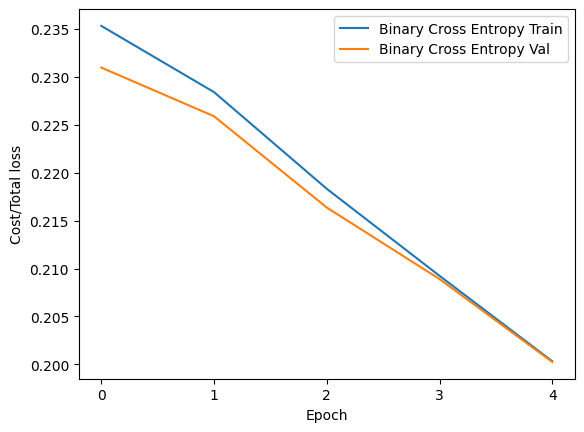

In [43]:
plt.plot(range(len(dict_metrics['loss_train'])), [loss.detach().numpy() for loss in dict_metrics['loss_train']], label="Binary Cross Entropy Train")
plt.plot(range(len(dict_metrics['loss_val'])), [loss.detach().numpy() for loss in dict_metrics['loss_val']], label="Binary Cross Entropy Val")
plt.xlabel('Epoch')
plt.ylabel('Cost/Total loss')
plt.xticks(range(len(dict_metrics['loss_train'])))
plt.legend();

### Évaluation du modèle
Après l'entraînement, évalueation du modèle sur un jeu de données de test pour vérifier ses performances

In [ ]:
model.eval()
# Code pour évaluer le modèle sur un jeu de données de test